# Evaluation of our Neural Network Model (on GloVe vectorized dataset).


## Import useful libraries.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import string
import re
import nltk
import pickle

from gensim.utils import simple_preprocess
from gensim import corpora

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.metrics import recall_score,f1_score,precision_score,classification_report,roc_curve,auc
from sklearn.model_selection import cross_val_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from google.colab import drive
drive.mount('/content/drive/')
nltk.download('wordnet')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Retrieve and clean our dataset.

### Retrieve and display our dataset!

In [ ]:
data = pd.read_csv(r'/content/drive/My Drive/AI(II)/datasets/SentimentTweets.csv')

X = pd.DataFrame(data['text'],columns=['text'])
Y = pd.DataFrame(data['target'],columns=['target'])

display(X,Y)

,text
0,#brokenpromises...
1,David Carradine so sad. Thai's law not sure i...
2,A @ 415 B @ 425. Tell your bro i say congrats!
3,@littlefluffycat Indeed.
4,Completed Race 4 Life in 58mins with girlies f...
...,...
1279995,@zawhtutwin watching cartoon and cry? oh i do ...
1279996,is eating mcdonalds
1279997,@BestSoyLatte So sorry to hear about your car....
1279998,@leesherry you have done what you could. Forgi...


,target
0,0
1,0
2,4
3,4
4,4
...,...
1279995,4
1279996,4
1279997,0
1279998,4


### Convert to lowercase.

In [ ]:
X['text'] = X['text'].str.lower()
display(X)

,text
0,#brokenpromises...
1,david carradine so sad. thai's law not sure i...
2,a @ 415 b @ 425. tell your bro i say congrats!
3,@littlefluffycat indeed.
4,completed race 4 life in 58mins with girlies f...
...,...
1279995,@zawhtutwin watching cartoon and cry? oh i do ...
1279996,is eating mcdonalds
1279997,@bestsoylatte so sorry to hear about your car....
1279998,@leesherry you have done what you could. forgi...


### Replace where is 4 to 1 (binary form).

In [ ]:
Y = Y.replace(4,1)
display(Y)
print(Y.value_counts())

,target
0,0
1,0
2,1
3,1
4,1
...,...
1279995,1
1279996,1
1279997,0
1279998,1


target
1         640609
0         639391
dtype: int64


### Removal of special characters and punctuation.

In [ ]:
def remove_special_characters(text, remove_digits=True):
  pattern = r'[^a-zA-z0-9\s]'
  text = re.sub(pattern,'',text)
  return text

X['text'] = X['text'].apply(lambda x:''.join([i for i in x if i not in string.punctuation]))

X['text'] = X['text'].apply(remove_special_characters)

display(X)

,text
0,brokenpromises
1,david carradine so sad thais law not sure if ...
2,a 415 b 425 tell your bro i say congrats
3,littlefluffycat indeed
4,completed race 4 life in 58mins with girlies f...
...,...
1279995,zawhtutwin watching cartoon and cry oh i do th...
1279996,is eating mcdonalds
1279997,bestsoylatte so sorry to hear about your carth...
1279998,leesherry you have done what you could forgive...


### Tokenization.

In [ ]:
X['text'] = [simple_preprocess(line, deacc=True) for line in X['text']] 

display(X)

,text
0,[brokenpromises]
1,"[david, carradine, so, sad, thais, law, not, s..."
2,"[tell, your, bro, say, congrats]"
3,"[littlefluffycat, indeed]"
4,"[completed, race, life, in, mins, with, girlie..."
...,...
1279995,"[zawhtutwin, watching, cartoon, and, cry, oh, ..."
1279996,"[is, eating, mcdonalds]"
1279997,"[bestsoylatte, so, sorry, to, hear, about, you..."
1279998,"[leesherry, you, have, done, what, you, could,..."


### Lemmatization.

In [ ]:
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return " ".join([lemmatizer.lemmatize(w, pos="v") for w in text])

X['text'] = X['text'].apply(lemmatize_text).copy()

display(X)

,text
0,brokenpromises
1,david carradine so sad thais law not sure if i...
2,tell your bro say congrats
3,littlefluffycat indeed
4,complete race life in mins with girlies from w...
...,...
1279995,zawhtutwin watch cartoon and cry oh do that al...
1279996,be eat mcdonalds
1279997,bestsoylatte so sorry to hear about your carth...
1279998,leesherry you have do what you could forgivene...


### Split dataset to train,validation and test dataset.


In [ ]:
# Split dataset to train and test set.
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.005,random_state=42)

# Split train dataset to train and validation set.
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.005,random_state=42)

print("X_train's shape:", X_train.shape)
print("Y_train's shape:", Y_train.shape)
print("X_val's shape:", X_val.shape)
print("Y_val's shape:", Y_val.shape)
print("X_test's shape:", X_test.shape)
print("Y_test's shape:", Y_test.shape)

X_train's shape: (1267232, 1)
Y_train's shape: (1267232, 1)
X_val's shape: (6368, 1)
Y_val's shape: (6368, 1)
X_test's shape: (6400, 1)
Y_test's shape: (6400, 1)


>We choosed to split dataset 99%-1% (train and test set), cause our dataset is too large. 


## Vectorization.

### Vectorization with use of pre-trained model GloVe.

#### Use pre-trained model GloVe so as to create glove dictionary (and save it, cause take a lot of time and memory).

In [ ]:
# vectors = []
# words = []
# word2id = {}
# id=0
# with open('/content/drive/My Drive/AI(II)/glove_models/glove.6B.50d.txt', 'rb') as f:
#   for l in f:
#     line = l.decode().split()
#     word = line[0]
#     words.append(word)
#     word2id[word] = id
#     id += 1
#     vec = np.array(line[1:]).astype(np.float)
#     vectors.append(vec)

# # Create dictionary glove.
# glove_dict = {w: vectors[word2id[w]] for w in words}

# # Save dictionary glove.
# glove_file = open('/content/drive/My Drive/AI(II)/glove_dicts/glove_dict_50.pkl', 'wb')
# pickle.dump(glove_dict,glove_file)
# glove_file.close()

#### GloVe Vectorization.

In [ ]:
# Implementation of function which vectorizes via GloVe pre-trained model.
def glove_vec(dataset):

  # Load dictionary glove.
  glove_file = open('/content/drive/My Drive/AI(II)/glove_dicts/glove_dict_50.pkl', 'rb')
  glove = pickle.load(glove_file)
  
  # Define important variables.
  dims = len(glove['and'])
  words=0
  words_found=0
  mean_tweets = []

  # Iterate for each tweet of dataset
  for index,tweet in enumerate(dataset['text']):

    # Split tweet into words
    words_of_tweet = str(tweet).split(' ')

    # Define empty list of mean vector of each tweet.
    vectors_of_tweet = np.zeros((len(words_of_tweet),dims))

    # Iterate through all words of each tweet.
    for j,word in enumerate(words_of_tweet):
      words += 1

      # If word is inside glove dictionary obtain vector.
      if word in glove:
        vectors_of_tweet[j] = glove[word]
        words_found += 1
    
    # Add to mean_tweets mean vector of each tweet.
    mean_tweets.append(np.mean(vectors_of_tweet,axis=0))

  glove_file.close()

  return np.array(mean_tweets),round((words_found/words),2)

# Vectorize X_train dataset with glove_vec().
glove_X_train,ratio1 = glove_vec(pd.DataFrame(X_train))

# Vectorize X_val dataset with glove_vec().
glove_X_val,ratio2 = glove_vec(pd.DataFrame(X_val))

# Vectorize X_test dataset with glove_vec().
glove_X_test,ratio3 = glove_vec(pd.DataFrame(X_test))

print("Ratios of words found:",ratio1,ratio2,ratio3)
print("glove_X_train's shape:",glove_X_train.shape)
print("glove_X_val's shape:",glove_X_val.shape)
print("glove_X_test's shape:",glove_X_test.shape)

Ratios of words found: 0.92 0.92 0.92
glove_X_train's shape: (1267232, 50)
glove_X_val's shape: (6368, 50)
glove_X_test's shape: (6400, 50)


#### Convert glove_X datasets to tensors with help of library PyTorch.


In [ ]:
# Convert X datasets to tensors with function convert_to_tensor.
glove_X_train = torch.tensor(glove_X_train)
glove_X_val = torch.tensor(glove_X_val)
glove_X_test = torch.tensor(glove_X_test)

print("glove_X_train's shape:", glove_X_train.shape)
print("glove_X_val's shape:", glove_X_val.shape)
print("glove_X_test's shape:", glove_X_test.shape)

glove_X_train's shape: torch.Size([1267232, 50])
glove_X_val's shape: torch.Size([6368, 50])
glove_X_test's shape: torch.Size([6400, 50])



### Convert Y datasets (labels) to tensors with help of library PyTorch.

In [ ]:
# Convert Y labels to tensors with torch.squeeze.
Y_train = torch.squeeze(torch.from_numpy(Y_train.to_numpy()).float())
Y_val = torch.squeeze(torch.from_numpy(Y_val.to_numpy()).float())
Y_test = torch.squeeze(torch.from_numpy(Y_test.to_numpy()).float())

print("Y_train's shape:", Y_train.shape)
print("Y_val's shape:", Y_val.shape)
print("Y_test's shape:", Y_test.shape)

Y_train's shape: torch.Size([1267232])
Y_val's shape: torch.Size([6368])
Y_test's shape: torch.Size([6400])


## Prepare GPU Cuda.

### Initial step with PyTorch, check if gpu cuda is available.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cpu


### Transfer all the computation to GPU (cuda device).


In [ ]:
glove_X_train = glove_X_train.to(device)
glove_X_val = glove_X_val.to(device)
glove_X_test = glove_X_test.to(device)

Y_train = Y_train.to(device)
Y_val = Y_val.to(device)
Y_test = Y_test.to(device)

## Implementation of function, which is gonna train our model.

In [ ]:
def calculate_accuracy(y_true, y_pred):  
  y_pred = torch.round(y_pred)
  correct = (y_true == y_pred).float() 
  acc = correct.sum() / len(correct)
  return acc

def train_model(model,criterion,optimizer,x_train,x_val,y_train,y_val,epochs=1000,batch_size=10000):

  # Declare empty lists.
  train_losses = []
  train_accs = []
  val_losses = []
  val_accs = []

  # Split train dataset to mini batches
  X_train_mini_batches = torch.split(x_train,batch_size)
  Y_train_mini_batches = torch.split(y_train,batch_size)

  # Start training
  for epoch in range(epochs):
    
    # Clear previous values of variables.
    epoch_loss = 0
    epoch_acc = 0
    validation_loss = 0
    val_acc = 0

    for X_train_mini_batch,Y_train_mini_batch in zip(X_train_mini_batches,Y_train_mini_batches):

      # Forward pass to get output.
      train_pred = model.forward(X_train_mini_batch.float())
      train_pred = torch.squeeze(train_pred)
      
      # Calculate Loss.
      train_loss = criterion(train_pred,Y_train_mini_batch)
      
      # Clearing up accumulated gradients.
      optimizer.zero_grad()
      
      # Getting gradients w.r.t. parameters.
      train_loss.backward()

      # Updating parameters.
      optimizer.step()

      # Add each mini batch's loss.
      epoch_loss += train_loss.item()

      # Add each mini batch's accuracy.
      epoch_acc += calculate_accuracy(Y_train_mini_batch,train_pred)

    # For each epoch test our model on validation set.
    val_pred = model.forward(x_val.float())
    val_pred = torch.squeeze(val_pred)
      
    # Calculate Loss
    val_loss = criterion(val_pred,y_val) 

    # Calculate val's loss
    validation_loss = val_loss.item()

    # Calculate val's accuracy
    val_acc = calculate_accuracy(y_val,val_pred)

    # Calculate mean loss and mean accuracy for train data.
    epoch_loss /= len(X_train_mini_batches)
    epoch_acc /= len(X_train_mini_batches)
    
    # Add them to appropriate lists so as to return them.
    val_losses.append(validation_loss)
    val_accs.append(val_acc)
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)

  return train_losses,val_losses,train_accs,val_accs

## First Neural Network Model.

### Implementation of class FirstModel, which is our first Neural Network.

In [ ]:
class FirstModel(nn.Module):
    
  def __init__(self,input_dim,hidden_dim1,hidden_dim2):
    super(FirstModel, self).__init__()     
    
    self.relu = nn.ReLU()
    
    self.layer1 = nn.Linear(input_dim, hidden_dim1) 
    self.layer2 = nn.Linear(hidden_dim1, hidden_dim2) 
    self.layer3 = nn.Linear(hidden_dim2, 1) 
  
  def forward(self, x):

    # Layer 1
    out = self.relu(self.layer1(x))
 
    # Layer 2
    out = self.relu(self.layer2(out))

    # Layer 3
    out = torch.sigmoid(self.layer3(out))

    return out 

  def evaluate(self,x_test,y_test,report=False):

    # Forward pass to get predictions.
    test_pred = self.forward(x_test.float())
    test_pred = torch.squeeze(test_pred)
    
    # Score by manually implemented calculate accuracy
    test_acc = round(calculate_accuracy(y_test,test_pred).item(),2)

    # Classification report
    if report==True:
      test_pred = test_pred.ge(.5).view(-1).cpu()
      y_test = Y_test.cpu()
      print(classification_report(y_test,test_pred))

    return test_acc  

### Prepare our first non deep feed forward neural network model.

In [ ]:
input_units = glove_X_train.shape[1]
hidden_units1 = 64
hidden_units2 = 16
learning_rate = 1e-4
w_decay = 1e-4

# Define our first feed forward neural network with glove vectorized input dataset.
glove_first_model = FirstModel(input_units,hidden_units1,hidden_units2)

# Define loss function.
criterion = nn.BCELoss()

# Define as optimizer Adam.
optimizer = optim.Adam(glove_first_model.parameters(),lr=learning_rate,weight_decay=w_decay)

# Transfer all the computation to GPU (cuda device).
glove_first_model.to(device)
criterion = criterion.to(device)

### Train our first model with GloVe vectorized input.

In [ ]:
# Call train_model with appropriate args and store into lists losses and accuracies.
glove_train_losses,glove_val_losses,glove_train_accs,glove_val_accs = train_model(glove_first_model,criterion,optimizer,glove_X_train,glove_X_val,Y_train,Y_val,epochs=100,batch_size=10000)

### Let's check what happened in training on first GloVe model.


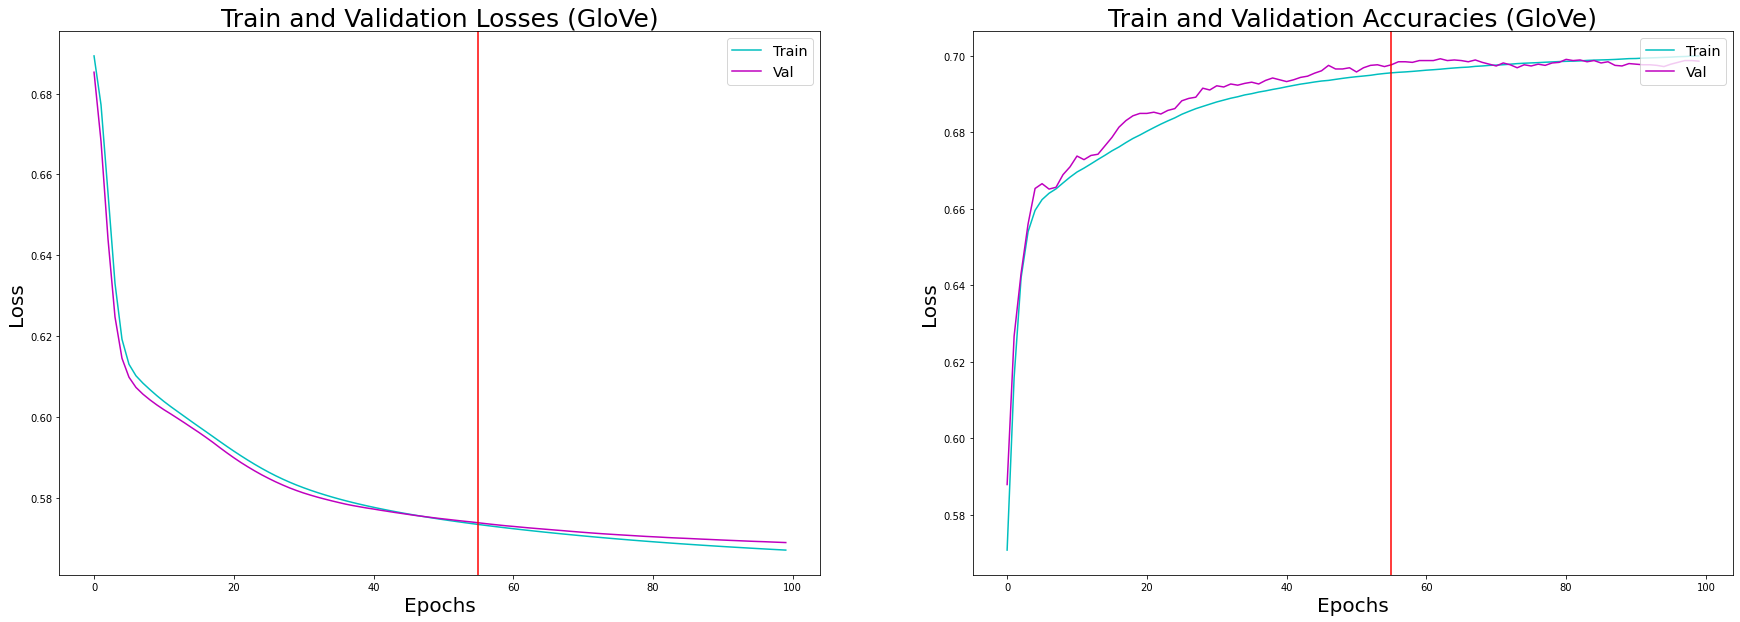

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(30,10))

early_stopping = 55

# Plot Train and Validation Losses with GloVe vectorization.
axs[0].set_title("Train and Validation Losses (GloVe)",size=25)
axs[0].set_ylabel('Loss', fontsize = 20.0) 
axs[0].set_xlabel('Epochs', fontsize = 20) 
_=axs[0].plot(glove_train_losses,'-c')
_=axs[0].plot(glove_val_losses,'-m')
_=axs[0].axvline(x=early_stopping,color='r')
_=axs[0].legend(('Train','Val'),loc='upper right',fontsize='x-large')

# Plot Train and Validation Accuracies with GloVe vectorization.
axs[1].set_title("Train and Validation Accuracies (GloVe)",size=25)
axs[1].set_ylabel('Loss', fontsize = 20.0) 
axs[1].set_xlabel('Epochs', fontsize = 20) 
_=axs[1].plot(glove_train_accs,'-c')
_=axs[1].plot(glove_val_accs,'-m')
_=axs[1].axvline(x=early_stopping,color='r')
_=axs[1].legend(('Train','Val'),loc='upper right',fontsize='x-large')

> As we can observe from learning curves GloVe model has a good fit until approximately epoch=55. After epoch=55 val loss starts rising up and be greater than train loss, so this is the point when overfitting has begun. So with the technique of early stopping we can stop training at this point in order to avoid overfitting.

### Evaluation of our first model with classification report and with manually implemented calculate_accuracy() function.

In [ ]:
print("GloVe Model Test's Accuracy:",glove_first_model.evaluate(glove_X_test,Y_test,True))

              precision    recall  f1-score   support

         0.0       0.71      0.69      0.70      3240
         1.0       0.69      0.71      0.70      3160

    accuracy                           0.70      6400
   macro avg       0.70      0.70      0.70      6400
weighted avg       0.70      0.70      0.70      6400

GloVe Model Test's Accuracy: 0.7


### General Notes about our GloVe NN model.

> Our Neural Network Model has the above structure:

> input dimensions (Relu) -> 64 (Relu) -> 16 (Sigmoid) -> 1

> For input of NN we manually vectorized each word from each tweet (with help of GloVe pre-trained model) and calculate mean vector of each tweet (50 dimensions). In that way we could load whole dataset and our model trained really quickly, due to small number of dimensions,50.

### Experiment's Conclusions.

> After many experiments with our model we observe that in order to avoid overfitting we had to choose a simplier model architecture, so we tried non deep NN model with 1 and 2 hidden layers. But seemed that model with 1 hidden layer underfitted so we choose 2 hidden layers.

> After studying and reading in articles and books with topic 'Machine Learning' and 'Deep Learning', out there everybody for binary classification problems recommends as criterion Binary Cross Entropy Loss and as optimizer with descent performance Adam. I can confirm these thoughts cause other criterions and optimizers didn't perform well.

> After that we randomly found the appropriate learning rate, which is the most significant parameter, so as to have a good fit. 

> The weight decay parameter adds a L2 penalty to the cost which can effectively lead to to smaller model weights. This helped us a lot with tackling overfitting.

> We set batch size to default 10.000, cause we have a huge dataset so as to run our model much faster.

> We experimented a lot with number of hidden units and finally ended up to 64 and 16 respectively. We prefer hidden units to be 2^k in order to help memory management of our computer.


